<a href="https://colab.research.google.com/github/tamburins/ESAA_2023/blob/main/ESAA_3_24_handson(245_271%2C_ch7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7 앙상블 학습과 랜덤 포레스트

- 무작위로 선택된 수천명의 답은 전문가의 답보다 나을 수 있는 것을 대중의 지혜라 하는데, 이와 유사하게 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 수집할 수 있다. 이러한 일련의 예측기를 앙상블, 이를 앙상블 학습, 앙상블 학습알고리즘을 앙상블 방법이라 함

- 예를 들어 훈련세트로부터 무작위로 각자 다른 서브셋을 만들어 일련의 결정트리 분류기를 훈련시킬 수도 있다. 개별 트리의 예측을 구하고 가장 많은 선택을 받은 클래스를 예측으로 삼는 것으로 이러한 결정트리 앙상블을 랜덤포레스트라 한다.

## 7.1 투표 기반 분류기

- 정확도가 80퍼센트인 분류기 여러개를 훈련시킨다고 가정하면 더 좋은 분류기를 만들기 위해 각 분류기의 예측을 모아 가장 많이 선택된 클래스를 에측하는, 다수결투표로 정해지는 직접 투표 분류기를 쓸 수 있음

- 이러한 다수결 투표분류기는 가장 좋은 개별 분류기보다 정확도가 높을 수 있으며 각 분류기가 약한학습기일지라도 충분히 많고 다양하면 높은 정확도를 보이는 강한 학습기가 될 수 있다.

- 큰수의 법칙 때문으로 앞뒷면 나올 확률이 다른 불규칙한 동전에서 시행횟수가 늘어날 수록 다른 확률에 가까워지는 것을 확인할 수 있기 때문

- 이와 비슷하게 무작위추측보다 조금더 나은 51%의 정확도를 가진 1000개의 분류기로 앙상블 모델을 구축한다 가정하다. 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있다. 물론 이것은 모든 분류기가 완벽하게 독립이고 오차에 상관관계가 없어야 가능한 것으로 동일 데이터에서는 불가능한 일이다.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
     

In [9]:
#VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [11]:
#check accuracy_score
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


예상대로 투표기반 분류기가 다른 개별 분류기보다 성능이 더 높다

- 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예츠긍ㄹ 평균내어 확률이 가장 높은 클래스를 예측할 수 있는데, 이를 간접투표 방식이라 하며 voting="soft" 옵션지정과 모든 분류기가 확률을 추정할 수 있도록 하면 된다.

- SVC는 기본값에서 클래스확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 함

## 7.2 배깅과 페이스팅
- 각기 다른 훈련 알고리즘을 사용하거나 같은 알고리즘 & 훈련세트의 서브셋 무작이 구성 > 다른 학습을  진행하는 방법도 존재하는데, 훈련세트에서 중복을 허용하여 샘플링 하는 방식을 배깅, 중복을 허용하지 않고 샘플링하는 방식을 페이스팅이라 한다.

- 배깅과 페이스팅에는 같은 훈련샘플을 여러개의 예측기에 걸쳐 사용할 수 있으나 배깅만이 한 예측기를 위해 훈련샘플을 여러번 샘플링할 수 있음

- 모든 예측기 가 훈련을 마치면 앙삳블은 모든 예측기이 예측을 모아 새 샘플에 대한 예측을 만드는데, 수집함수는 통계적  최빈값( 직접 투표 분류기처럼 가장 많은 예측 결과 )이고, 회귀에 대해서는 평균을 계산하는 것으로, 개별 예측기는 편향될 수 있으나 수집함수를 통과하는 것으로서 편향과 분산을 모두 감소시킬 수 있음

## 7.2.1 사이킷런의 배깅과 페이스팅
- 각 분류기는 훈련세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련되며, n_jobs는 사이킷런이 훈련과 예측에 사용할 CPU 코어수를 지정하면 됨(-1로 지정하면 가능한 모든 코어를 지정함)

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples = 100, bootstrap=True, n_jobs=-1)
bag_clf. fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- 단일 결정트리의 결정경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교하면, 앙삳블의 예측이 결정트리 하나의 예측보다 일반화가 훨씬 잘된 것으로 추정된다. 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.

- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높일 수 있으나 예측기간의 상관관계를 줄이므로 앙사블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 사용하기 때문에 선호되나 시간과 CPU여유가 된다면 교차검증으로 배깅과 페이스팅을 모두 평가해 더 나은 쪽을 선택하는 것이 좋다.

## 7.2.2 oob 평가

- 배깅을 사용하면 어떤 샘플은 여러번 사용되고 어떤 샘플은 전혀 선택되지 않을 수 있는데 평균적으로 37%가 이렇게 선택되지 않은 샘플로 oob 샘플이라 칭함

- 예측기가 훈련되는 동안은 obb를 사용하지 않으므로 이를 사용해 평가할 수 있다. 앙상블의 평가는 각 예측기의 oob평가를 평균하여 얻을 수 잇음

- 사이킷런의 baggingClassifier를 생성시 oob_score = True로 지정하면 자동으로 이를 수행함

In [22]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [23]:
#check accuracy_score
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

- 샘플에 대한 결정함수의 값도 obb_decision_function 변수에서 확인할 수 있다.이 경우 결정함수는 각 훈련샘플의 클래스 확률을 반환한다. 

In [24]:
bag_clf.oob_decision_function_

array([[0.39772727, 0.60227273],
       [0.36627907, 0.63372093],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06403941, 0.93596059],
       [0.32195122, 0.67804878],
       [0.01176471, 0.98823529],
       [0.99421965, 0.00578035],
       [0.97660819, 0.02339181],
       [0.77142857, 0.22857143],
       [0.00568182, 0.99431818],
       [0.8134715 , 0.1865285 ],
       [0.84615385, 0.15384615],
       [0.96174863, 0.03825137],
       [0.0621118 , 0.9378882 ],
       [0.        , 1.        ],
       [0.98421053, 0.01578947],
       [0.91758242, 0.08241758],
       [0.98360656, 0.01639344],
       [0.03365385, 0.96634615],
       [0.32748538, 0.67251462],
       [0.89502762, 0.10497238],
       [1.        , 0.        ],
       [0.97409326, 0.02590674],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6576087 , 0.3423913 ],
       [0.

이 경우 양성에 속할 확률 68퍼센트, 음성에 속할 확률 31퍼센트로 추정

## 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원하는데 샘플링은 max_features, bootstrap_features 두개의 매개변수로 조절되는데, 이는 고차원의 데이터셋을 다룰 때 유용한 것으로, 훈련특성과 샘플을 모두 사용하는 샘플링 방식을 랜덤패치방식, 훈련샘플을 모두 사용하고(bootstrap=False, max_samples=1.0) 특성은 샘플링하는(bootstrap_features=True max_features<1.0)을 랜덤 서브 스페이스방식이라 함

## 7.4 랜덤 포레스트
랜덤 포레스트는 일반적으로 배깅방법을 적용한 결정트리의 앙상블로 max_samples를 훈련세트의 크기로 지정하고 baggingclassifier에 decesiontreeclassifier를 넣어 만드는 대신 결정트리에 최적화되어 사용하기 편리한 randomforestclassfifier를 사용할 수 도 있음

아래는 500개의 트리로 이뤄진 랜덤폴ㅇ스트 분류기를 여러 CPU코어에서 훈련시키는 코드이다

In [27]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 랜포 분류기는 몇가지 예외가 있으나 결정트리 분류기의 매개변수와 앋상블 자체를 제어한느데 필요한 배깅분류기의 매개변수를 모두 갖고있다.

- 랜덤포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성중에서 최선으 ㅣ특성을 찾는 대신 무작위로 선택한 특성 후보중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입합니다. 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어낸다.





In [30]:
# baggingclassifier를 이용해 랜포와 유사하게 만들면?
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### 7.4.1 엑스트라 트리
- 랜포에서 트리 생성시 무작위성을 분할에 사용하는데, 이 떄 무작위성을 증가시키기 위해 최적의 임계값을 찾는 대신 후보특성을 사용해 무작위로 분할한 뒤 그 중 최상의 분할을 선택함

- 이와같이 극단적으로 무작위한 트리의 랜포를 익스트림 랜덤트리 앙상블(엑스트라 트리)라 부른다. 여기서도 역시 편향이 늘어나지만 대신 분상르 낮추게 되는데 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜포보다는 빠름

- 엑스트라 트리 생성시 ExtraTreeClassifier를 생성하는데 이는 랜포분류기와 동이랗며 동일한 API를 제공함

### 7.4.2 특성 중요도

- 랜덤포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉬운 것으로 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확ㅇ니하여 특성의 중요도를 측정

- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체합이 1이되도록 결괏값을 정규화하는데 이 값은 feature_importances에 저장되어 있다!



In [36]:
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10549454293760344
sepal width (cm) 0.022452717648742935
petal length (cm) 0.4437330683935289
petal width (cm) 0.4283196710201248


## 7.5 boosting
부스팅은 약한 학습기를 여러개 연결하여 강한 학습기를 생성하는 앙상블 방법으로 얖의 모델을 보완해나가면서 일련의 예측기를 학습시키는 아이디어이다.

### 7.5.1 에이다부스트

- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련샘플의 가중치를 더 높이는 것으로 이렇게 하면 새 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다..

- 예를들어 에이다부스트 분류기를 만들 떄 알고맂므이 기반이 되는 첫번째 분류기를 훈련세트에서 훈련시키고 예측을 만들고 알고알고리즘맂므이 잘못 분류된 훈련샘플으 가중치를 상대적을 높인다. 두번째 분류기는 업데이트 된 가중치를 사용해 훈련세트에서 훈련하고 다시 예측을 만들어 다시 가중치를 업데이트 한다. 첫번째 분류기가 많은 샘플을 잘못 분류해 이 샘플들의 가중치가 높아지면 두번째 분류기는 이 샘플들을 더 정확히 예측하게 된다. 즉 잘못분류된 샘플의 가중치는 반복마다 절반마다 높아지는 것으로 이는 경사하강법과 유사하다. 경사하강법에서 비용함수를 최소화하기 위해 예측기의 머델파라미터를 조정해가는 반면 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가한다.

- 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅고 ㅏ비슷한 방식을 ㅗ예측을 생성하나 가중치가 적용된 훈련세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용된다.

- 에이다부스트 알고리즘의 각 샘플 가중치는 초기에 1/m으로 초기화되고 가중치가 적용된 에러율 r1이 훈련세트에 계산된다.

- 예측기의 가중치 alpha j는 식을 이용해 계산되는데, 여기서 학습률 하이퍼파라미터를 이용하여 예측기가 정확할수록 가중치가 더 높아지게 되며 무작위로 예측하는 정도라면 가중치가 0에 가깝게 될 것이다. 그러나 그보다 나쁘면 가중치는 음수가 된다.

- 에이다부스트 알고리즘이 식을 이용하여 샘플의 가중치를 업데이트하여 잘못 분류된 샘플의 가중치가 증가되고 모든 샘플의 가중치를 정규화한다.

- 마지막으로 새 예측기가 업데이트된 가중치를 사용해 훈련되고 전체과정이 반복되며, 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지된다. 예측 시 에이다부스트는 단순히 모든 예측기의 예측을 계산하고 예측기 가중치 alpha를 더해 예측 결과를 만든다. 가중치 합이 가장 큰 클래스가 예측 결과가 된다.

- 사이킷런은 SAMME라는 에이다부스트의 다중클래스 버전을 사용하는데 클래스가 두개일 때는 SAMME가 에이다부스트와 동일한데 예측기가 클래스의 확률을 추정할 수 있다면 사이킷런은 SAMMER이라는 SAMME의 변종을 사용하며 이 알고리즘은 예측값대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋다



In [37]:
# 200개의 얕은 결정트리 기반의 에이다부스트 분류기
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레디언트 부스팅

- 인기가 높은 또 하나의 부스팅 알고리즘 중 하나인 그레디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하나, 에이다부스트처럼 반복마다 샘플의 가중치를 추가하는 대신 이전예측기가 생성한 잔여오차에 새 예측기를 학습시킴

- 결정트리를 기반 예측기로 사용하는 간단한 회귀인 그레디언트 트리부스팅 혹은 그레디언트 부스티드 회귀트리를 학습해보고자 함

In [38]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [39]:
# 잔여오차 학습시키기
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)


DecisionTreeRegressor(max_depth=2)

In [40]:
# third regression model by generating with residual error
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [42]:
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))

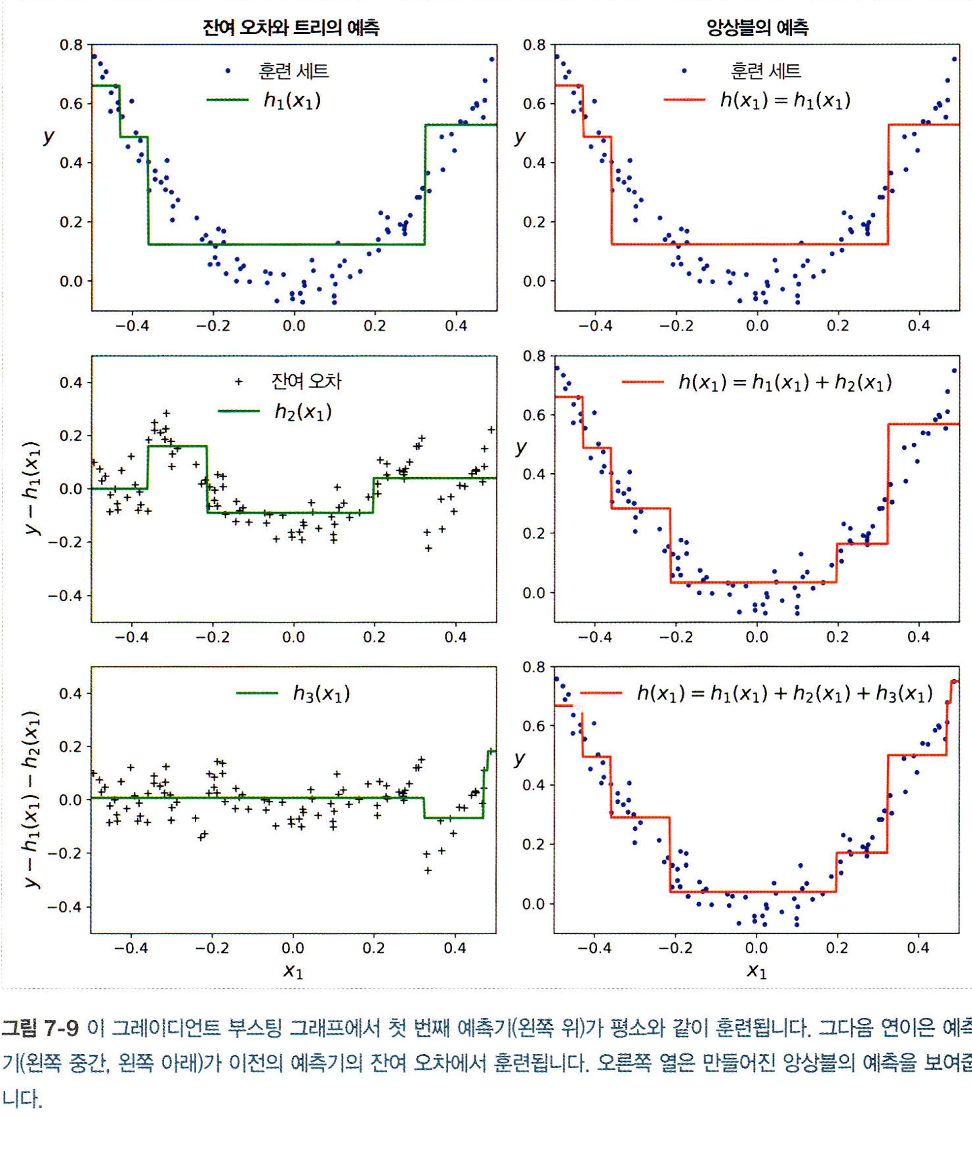

그림의 왼쪽열은 트리의 예측, 우측은 앙상블의 예측으로 첫번째는 앙상블에트리가 하나만 존재하여 양쪽이 동일하나, 트리가 첫번쨰 잔여오차에 대해 학습되고 누적하여 학습을 반복하며 앙상블의 예측이 점차 개선된느 것을 볼 수 있다.

- 사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있다. 트리수와 같이 앙상블의 훈련을 제어하는 매개변수는 물론 랜포리그레서와 유사하게 결정트리의 성장을 제어하는 매개변수를 가짐

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate가 각 트리의 기여정도를 조정하여 낮게 설정될 경우 많은트리를 필요로 하며 예측 성능이 개선되는데 이는 축소라 불리는 규제방법이다. 단 트리가 너무 많아도 과대적합될 수 있다.

- 최적의 트리수를 찾기 위해서는 조기종료 기법을 사용할 수 있으며 간단히는 staged_predict()메서드를 사용할 수 있다. 이는 훈련의 각 단계에서 앙상블에 의해 만들어진 에측기를 순화하는 반복자를 반환하는데, 다음 코드는 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리수를 찾기 위해 각 훈련단계에서 검증오차를 측정한다.

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_trian, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors=[mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=14)

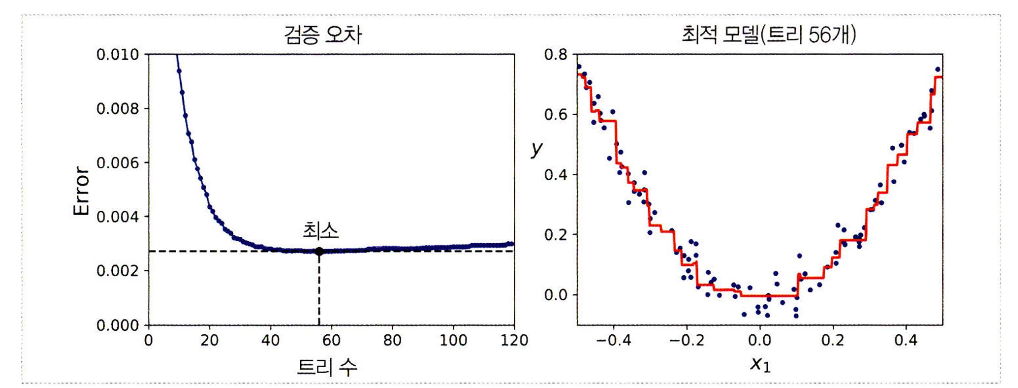

그림의 왼쪽은 검층오차, 우측은 최적모델로 많은 수의 트리를 먼저 훈련시키고 최적의 수를 살펴보는 대신 훈련을 중지하는 방법으로 조기종료를 구현할 수 있다. warm_start=True로 설정할 경우 사이킷런이 fit메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다. 다음 코드는 연속 다섯번의 반복동안 검증오차가 향상되지 않으면 훈련을 중지한다.

In [45]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up +=1
    if error_going_up==5:
      break #조기종료

- 그래디언트 부스팅 리그레서는 각 트리 훈련시 사용할 훈련샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원하는데, 이 서브샘플의 퍼센트만큼(0.25일경우 25퍼센트의) 무작위로 트리를 선택하여 훈련샘플로 학습한다. 이 경우 편향이 높아지지만 분산이 낮아지며 훈련속도가 높아지는데, 이를 확률적 그레디언트 부스팅이라 한다.

- 최적화된 그레디언트 붓팅구현으로 파이썬라이브러리인 XGBoost가 유명한데, 이는 빠른 속도와 확장성, 이식성을 목표로 한다.

In [46]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [47]:
#xgboost early stopping
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.49798
[1]	validation_0-rmse:0.50818


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


## 7.6 스태킹
- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수 대신 취합하는 모델을 훈련시킨다는 아이디어에서 시작한 스태킹은 마지막예측기인 블렌더 혹은 메타학습기를 학습시키는 것으로 주로 홀드아웃 세트를 이용한다.

- 먼저 훈련세트를 두개의 서브셋으로 나누는데 첫번째 서브셋은 레이어의 예측을 훈련시키기 위해 사용한다.

- 그 다음 첫번째 레이어의 예측기를 사용해 두번쨰 세트에 대한 예측을 생성한다. 예측기들이 훈련동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측들은 완전히 새로운 것으로 홀드아웃세트의 각 샘플에 대해 세개의 예측값이 있다. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력특성으로 사용하는 새로운 훈련세트를 만들 수 있따. 블렌더가 새 훈련세트로 훈련되는데 이는 첫번째 레이어의 예측을 갖고 타깃값을 예측하도록 학습된다.

- 유사한 방식으로 블렌더를 여러개 훈련시키는 것도 가능한데, 이럴 경우 블렌더만의 레이어가 생성되고 이 경우 훈련세트를 세개의 서브셋으로 나눈다. 첫번째 세트는 첫번째 레이어를 훈련시키는데, 두번째 세트는 첫번째 레이어의 예측기로 두번쨰 레이어를 훈련시키기 위한 훈련세트를 만드는데 사용된다. 그리고 세번째는 두번째 레이어의 예측기로 세번째 레이어를 훈련시키기 위한 훈련세트를 만드는데 사용된다. 작업이 종료되면 각 레이어를 차례대로 실행해 새 샘플에 대한 예측을 생성할 수 있다.

- 안타깝게도 사이킷런은 직접 스태킹을 지원하지 않으나 직접 구현이 어렵지는 않으며 오픈소스 구현 또한 활용 가능하다.